In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import cv2

import time
from os import makedirs, listdir
from os.path import join, exists

import matplotlib.pyplot as plt
from DH_equi2pers_v3 import equi2pers, equi2pers_non_ideal
from DH_pers2equi_v3 import pers2equi, pers2equi_non_ideal, pers2equi_change_num


In [29]:
## Image Load ##
img_BGR = cv2.imread('./office22_v3.png', cv2.IMREAD_COLOR) #'../output/__erp_img.png' 
img_BGR = cv2.resize(img_BGR, (1024, 512), interpolation = cv2.INTER_AREA) #(1024, 512) - pano & (256, 256) - rgb
img = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB) #BGR to RGB  [:,:,[2,1,0]]
## Define Vars ##
nrows=4
npatches=18
patch_size=(256, 256)
fov=(80, 80)
erp_size=(img.shape[0], img.shape[1])
layer_name='pred' #'weight'

In [54]:
patches = []
files = listdir('./office22/')
sorted_files = sorted(files)
for file in sorted_files:
    patch = cv2.imread(join('./office22/', file))
    patch = cv2.resize(patch, patch_size, interpolation = cv2.INTER_AREA)
    patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    patch = torch.from_numpy(np.transpose(patch, [2, 0, 1]).astype(np.float32)).unsqueeze(0)
    patches.append(patch)

patches = torch.cat(patches, dim=0).unsqueeze(-1).permute(4, 1, 2, 3, 0)
print(patches.shape)


# patch_BGR = cv2.imread(f'../data/camera_ffd2cca53bfe4dc580469bc1fffb077e_office_22_frame_2_domain_rgb.png', cv2.IMREAD_COLOR) # ../data/camera_ffd2cca53bfe4dc580469bc1fffb077e_office_22_frame_2_domain_rgb.png
# patch_BGR = cv2.resize(patch_BGR, (256, 256), interpolation = cv2.INTER_AREA) #(1024, 512) - pano & (256, 256) - rgb
# patch = cv2.cvtColor(patch_BGR, cv2.COLOR_BGR2RGB) #BGR to RGB  [:,:,[2,1,0]]

# patch_new = torch.from_numpy(np.transpose(patch, [2, 0, 1]).astype(np.float32)).unsqueeze(0)
# print(patch_new.shape)
#img_new = img_new.unsqueeze(0)


torch.Size([1, 3, 256, 256, 18])


In [24]:
randoms = np.round( np.random.uniform(-30, 30, (18, 2)) )
randoms = np.array(    [[-14.,  -3.], #u,v
                        [  1.,  -1.],
                        [ 20.,   9.],
                        [-30., -30.], 
                        [-30., -15.], #4
                        [-15.,  15.], #5
                        [ 10.,   5.], #6
                        [ 11.,  24.], #7
                        [-27., -11.],
                        [ 19.,  -1.],
                        [  2.,  26.],
                        [ 14.,  12.],
                        [-21.,  22.],
                        [ 20.,  15.],
                        [  4., -10.],
                        [ 20.,  21.],
                        [-20.,  -9.],
                        [  1.,  -2.]])

In [25]:
img_new = img.astype(np.float32) 
img_new = np.transpose(img_new, [2, 0, 1])
img_new = torch.from_numpy(img_new)
img_new = img_new.unsqueeze(0)

pers, _, _, _ = equi2pers(img_new, fov=fov, nrows=nrows, patch_size=patch_size)
pers_img = pers[0].permute(3, 1, 2, 0).numpy().astype(np.uint8)
print(pers.shape, img_new.shape)
### -> Pers Nonideal ###
pers_non, _, _, center_p = equi2pers_non_ideal(img_new, fov=fov, nrows=nrows, patch_size=patch_size, randoms=randoms)
pers_img_non = pers_non[0].permute(3, 1, 2, 0).numpy().astype(np.uint8)
#print(pers_img_non.shape)   

### -> Equi Nonideal ###
equi = pers2equi(pers, fov=fov, nrows=nrows, patch_size=patch_size, erp_size=erp_size) 
equi_img = equi[0].permute(1, 2, 0).numpy().astype(np.uint8)

equi_non = pers2equi_non_ideal(pers_non, fov, nrows, patch_size, erp_size, cp_random=center_p.clone())
equi_img_non = equi_non[0].permute(1, 2, 0).numpy().astype(np.uint8)

#change patch num 18 -> X
pickuplist = torch.tensor([4, 5, 6, 7]) # 3(0~2) 6(3~8) 6(9~14) 3(15~17) total 18 #[1, 4, 13, 16], [3, 4, 5, 6]
equi_non_partial= pers2equi_change_num(pers_non, fov, nrows, patch_size, erp_size, pickuplist, cp_random=center_p.clone())
equi_img_non_partial = equi_non_partial[0].permute(1, 2, 0).numpy().astype(np.uint8)

pickuplist = torch.tensor([4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]) # 3(0~2) 6(3~8) 6(9~14) 3(15~17) total 18 #[1, 4, 13, 16], [3, 4, 5, 6]
equi_patches= pers2equi_change_num(patches, fov, nrows, patch_size, erp_size, pickuplist)
equi_img_patches = equi_patches[0].permute(1, 2, 0).numpy().astype(np.uint8)

torch.Size([1, 3, 256, 256, 18]) torch.Size([1, 3, 512, 1024])
cp random ON


## Plot Pers / Equi

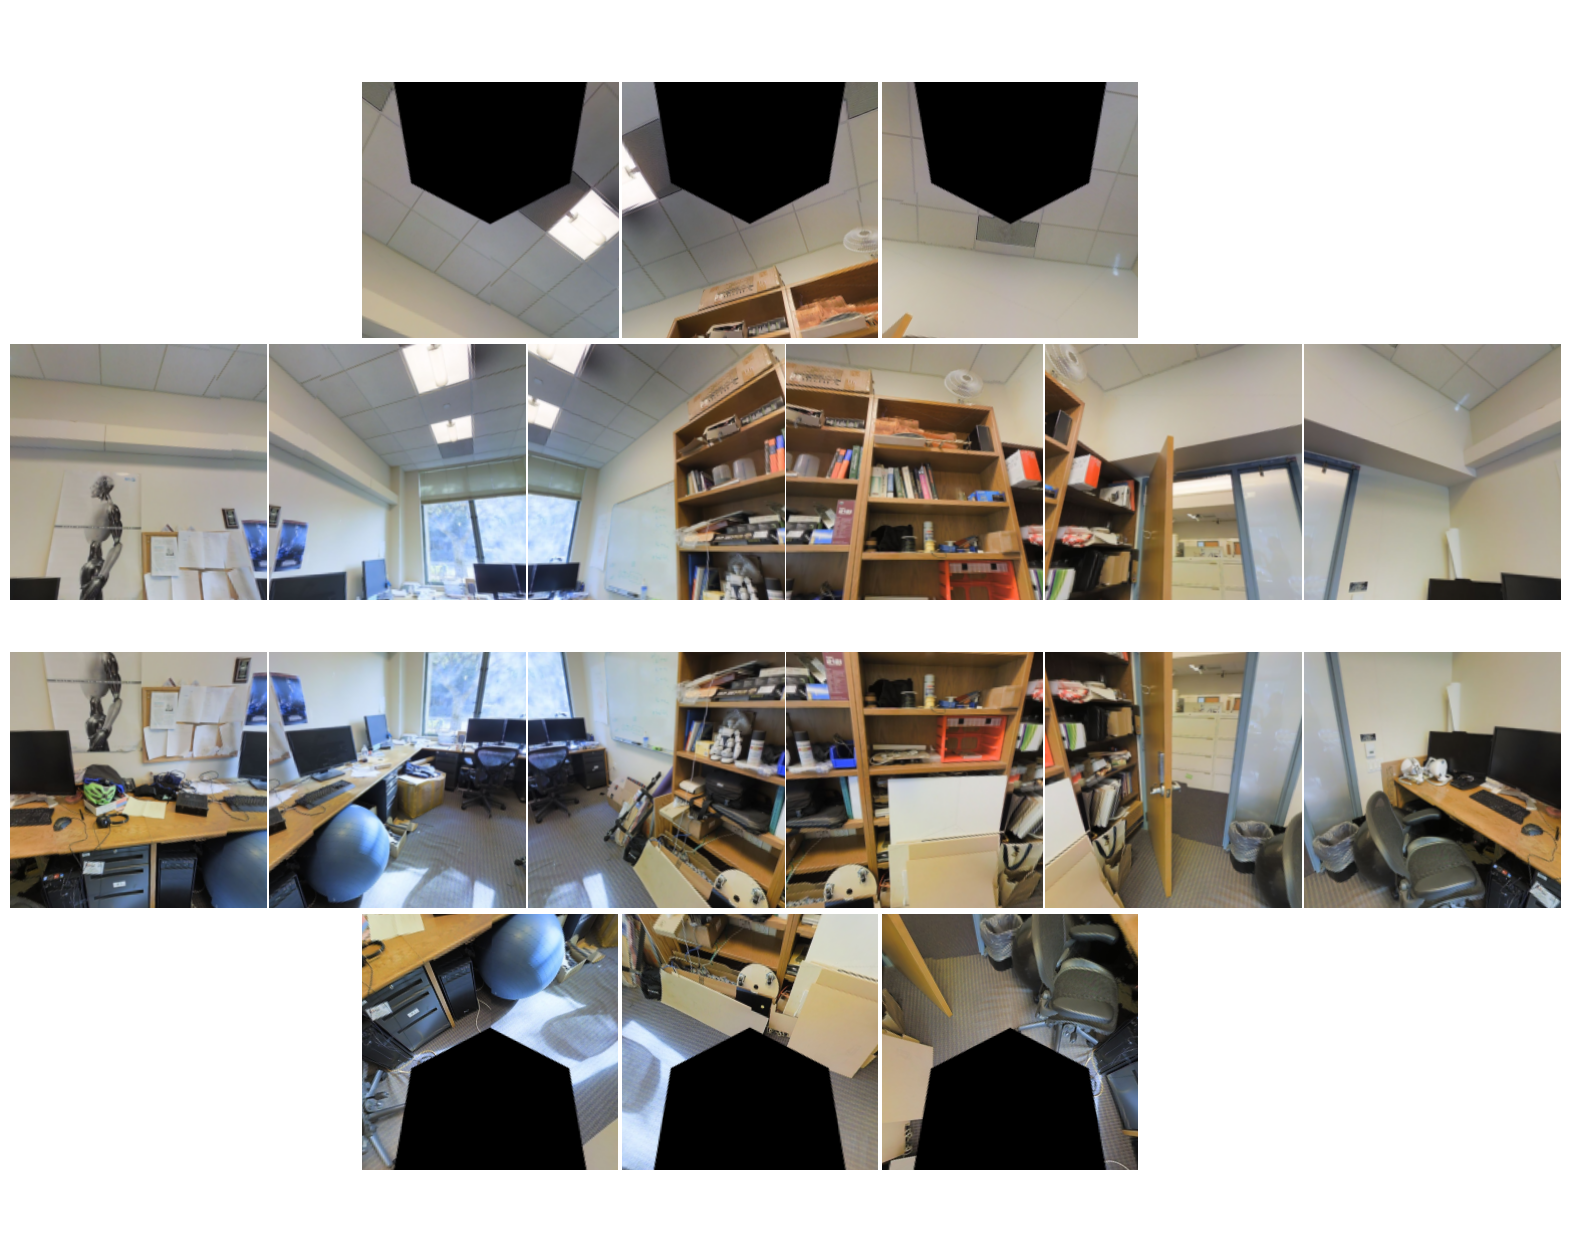

In [12]:
fig, axes = plt.subplots(4, 6, figsize=(20, 16))
fig.subplots_adjust(hspace=0, wspace=0.01)
for i in range(3):
    axes[0, i].imshow(pers_img[i])
    axes[3, i].imshow(pers_img[i+15])
for i in range(6):
    axes[1, i].imshow(pers_img[i+3])
    axes[2, i].imshow(pers_img[i+9])

for i in range(4):
    for j in range(6):
        axes[i, j].axis('off')
        pos = axes[i, j].get_position()
        #print(f"Subplot {i, j} position: x0={pos.x0:.2f}, y0={pos.y0:.2f}, width={pos.width:.2f}, height={pos.height:.2f}")

axes[0, 0].set_position([0.30, 0.675, 0.13, 0.16])
axes[0, 1].set_position([0.43, 0.675, 0.13, 0.16])
axes[0, 2].set_position([0.56, 0.675, 0.13, 0.16])
axes[3, 0].set_position([0.30, 0.155, 0.13, 0.16])
axes[3, 1].set_position([0.43, 0.155, 0.13, 0.16])
axes[3, 2].set_position([0.56, 0.155, 0.13, 0.16])
plt.show()       

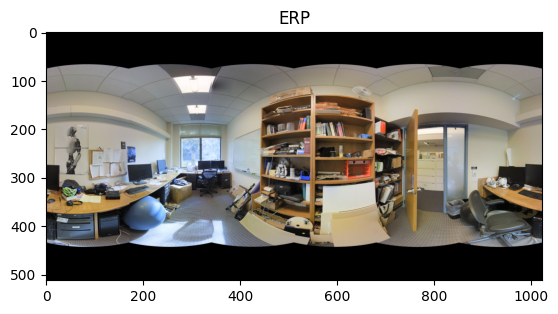

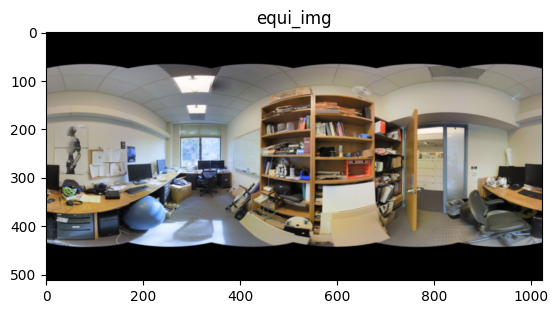

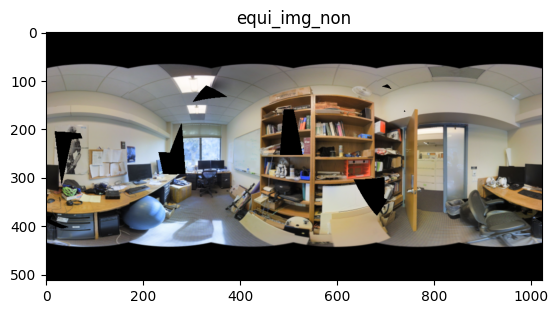

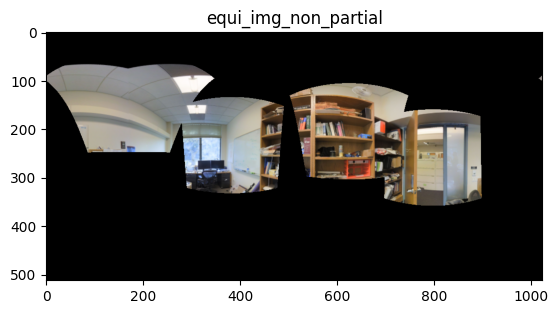

In [13]:
plt.title('ERP')
plt.imshow(img) 
plt.show()

plt.title('equi_img')
plt.imshow(equi_img)
plt.show()
plt.title('equi_img_non')
plt.imshow(equi_img_non)
plt.show()

plt.title('equi_img_non_partial')
plt.imshow(equi_img_non_partial)
plt.show()

## Metrics

In [14]:
import skimage.metrics as metrics
ssim_noise = metrics.structural_similarity(img, equi_img, multichannel=True, channel_axis=2) #, win_size=7 default
psnr = metrics.peak_signal_noise_ratio(img, equi_img)
mse_noise = metrics.mean_squared_error(img, equi_img)
print(f'ssim: {ssim_noise:.4f}, psnr: {psnr:.4f}, mse: {mse_noise:.4f}')

ssim: 0.9427, psnr: 29.9487, mse: 65.7975
